In [3]:
from dataloaders.datasets.coco import COCOSegmentation
from dataloaders import custom_transforms as tr
from dataloaders.utils import decode_segmap
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

from types import SimpleNamespace

Loading RGB-D and segmentation
-------

The depth and RGB are saved as seperate jpg files. Each is loaded seperately, then they are concatenated into a 4-channel image with the depth channel takeing the place of an alpha channel. All four channels are normalized and a random crop, horizontal flip, and gaussian blur are applied for image augmentation. The same transformation are applied to the segmentation mask.

Let's start by looking at a batch of 4 images and segmentation masks.

In [4]:
#Replacement for ArgumentParser for ipython
args = SimpleNamespace(base_size = 513, crop_size = 513)

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
Using RGB-D input


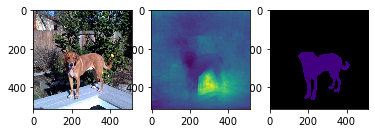

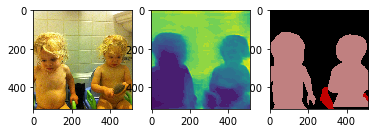

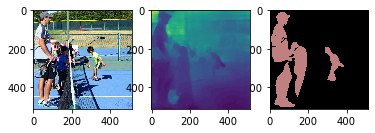

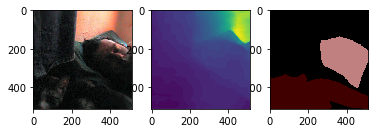

In [5]:
#Same as main method of dataloaders.datasets.coco
coco_val = COCOSegmentation(args, split='val', year='2017', use_depth=True)

dataloader = DataLoader(coco_val, batch_size=4, shuffle=True, num_workers=0)

for ii, sample in enumerate(dataloader):
    for jj in range(sample["image"].size()[0]):
        img = sample['image'].numpy()
        gt = sample['label'].numpy()
        tmp = np.array(gt[jj]).astype(np.uint8)
        segmap = decode_segmap(tmp, dataset='coco')
        img_tmp = np.transpose(img[jj], axes=[1, 2, 0])
        img_tmp *= coco_val.data_std
        img_tmp += coco_val.data_mean
        img_tmp *= 255.0
        img_tmp = img_tmp.astype(np.uint8)
        plt.figure()
        plt.title('display')
        plt.subplot(131)
        plt.imshow(img_tmp[:,:,:3])
        plt.subplot(133)
        plt.imshow(segmap)
        plt.subplot(132)
        plt.imshow(img_tmp[:,:,3])

    break

plt.show(block=True)

Load a saved model and visualize results
-----

The trained model takes the RGB-D image as input and produces a segmentation mask

In [6]:
import torch
import os
from dataloaders import make_data_loader
from modeling.sync_batchnorm.replicate import patch_replication_callback
from modeling.deeplab import *

In [7]:
#Pre-process arguments
def pre_process_args(args):
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    if args.cuda:
        try:
            args.gpu_ids = [int(s) for s in args.gpu_ids.split(',')]
        except ValueError:
            raise ValueError('Argument --gpu_ids must be a comma-separated list of integers only')

    if args.sync_bn is None:
        if args.cuda and len(args.gpu_ids) > 1:
            args.sync_bn = True
        else:
            args.sync_bn = False

    # default settings for epochs, batch_size and lr
    if args.epochs is None:
        epoches = {
            'coco': 30,
            'cityscapes': 200,
            'pascal': 50,
        }
        args.epochs = epoches[args.dataset.lower()]

    if args.batch_size is None:
        args.batch_size = 4 * len(args.gpu_ids)

    if args.test_batch_size is None:
        args.test_batch_size = args.batch_size

    if args.lr is None:
        lrs = {
            'coco': 0.1,
            'cityscapes': 0.01,
            'pascal': 0.007,
        }
        args.lr = lrs[args.dataset.lower()] / (4 * len(args.gpu_ids)) * args.batch_size


    if args.checkname is None:
        args.checkname = 'deeplab-'+str(args.backbone)
    print(args)
    return args

In [8]:
#Replacement for ArgumentParser for ipython
rgbd_args = SimpleNamespace(backbone = 'resnet', 
                       out_stride = 16,
                       dataset ='coco',
                       use_sbd = True,
                       workers = 4,
                       base_size = 513,
                       crop_size = 513,
                       sync_bn = None,
                       freeze_bn = False,
                       loss_type = 'ce',
                       epochs = 40,
                       start_epoch = None,
                       batch_size = 16,
                       test_batch_size = None,
                       use_balanced_weights = False,
                       lr = 0.01,
                       lr_scheduler = 'poly',
                       momentum = 0.9,
                       weight_decay = 5e4,
                       nesterov = False,
                       no_cuda = False,
                       use_depth = True,
                       gpu_ids = '0',
                       resume = 'run/coco/deeplab-resnet/experiment_10/checkpoint.pth.tar',
                       checkname = 'deeplab-resnet',
                       ft = False,
                       eval_interval = 1,
                       no_val = False
                 )
rgbd_args = pre_process_args(rgbd_args)


rgb_args = SimpleNamespace(backbone = 'resnet', 
                       out_stride = 16,
                       dataset ='coco',
                       use_sbd = True,
                       workers = 4,
                       base_size = 513,
                       crop_size = 513,
                       sync_bn = None,
                       freeze_bn = False,
                       loss_type = 'ce',
                       epochs = 40,
                       start_epoch = None,
                       batch_size = 16,
                       test_batch_size = None,
                       use_balanced_weights = False,
                       lr = 0.01,
                       lr_scheduler = 'poly',
                       momentum = 0.9,
                       weight_decay = 5e4,
                       nesterov = False,
                       no_cuda = False,
                       use_depth = False,
                       gpu_ids = '0',
                       resume = 'pretrained/deeplab-resnet.pth',
                       checkname = 'deeplab-resnet',
                       ft = False,
                       eval_interval = 1,
                       no_val = False
                 )

rgb_args = pre_process_args(rgb_args)

namespace(backbone='resnet', base_size=513, batch_size=16, checkname='deeplab-resnet', crop_size=513, cuda=True, dataset='coco', epochs=40, eval_interval=1, freeze_bn=False, ft=False, gpu_ids=[0], loss_type='ce', lr=0.01, lr_scheduler='poly', momentum=0.9, nesterov=False, no_cuda=False, no_val=False, out_stride=16, resume='run/coco/deeplab-resnet/experiment_10/checkpoint.pth.tar', start_epoch=None, sync_bn=False, test_batch_size=16, use_balanced_weights=False, use_depth=True, use_sbd=True, weight_decay=50000.0, workers=4)
namespace(backbone='resnet', base_size=513, batch_size=16, checkname='deeplab-resnet', crop_size=513, cuda=True, dataset='coco', epochs=40, eval_interval=1, freeze_bn=False, ft=False, gpu_ids=[0], loss_type='ce', lr=0.01, lr_scheduler='poly', momentum=0.9, nesterov=False, no_cuda=False, no_val=False, out_stride=16, resume='pretrained/deeplab-resnet.pth', start_epoch=None, sync_bn=False, test_batch_size=16, use_balanced_weights=False, use_depth=False, use_sbd=True, wei

In [9]:
## Load saved model
def load_model(args):
    model = DeepLab(num_classes= dataloader.dataset.NUM_CLASSES,
                    backbone=args.backbone,
                    output_stride=args.out_stride,
                    sync_bn=args.sync_bn,
                    freeze_bn=args.freeze_bn,
                    use_depth=args.use_depth)

    if args.cuda:
        model = torch.nn.DataParallel(model, device_ids=args.gpu_ids)
        patch_replication_callback(model)
        model = model.cuda()

    if not os.path.isfile(args.resume):
        raise RuntimeError("=> no checkpoint found at '{}'" .format(args.resume))
    checkpoint = torch.load(args.resume)
    args.start_epoch = checkpoint['epoch']
    if args.cuda:
        model.module.load_state_dict(checkpoint['state_dict'])
    else:
        model.load_state_dict(checkpoint['state_dict'])
    best_pred = checkpoint['best_pred']
    print("=> loaded checkpoint '{}' (epoch {})"
          .format(args.resume, checkpoint['epoch']))
    return model

In [10]:
rgbd_model = load_model(rgbd_args)
rgb_model = load_model(rgb_args)

rgbd_model.eval()
rgb_model.eval()

=> loaded checkpoint 'run/coco/deeplab-resnet/experiment_10/checkpoint.pth.tar' (epoch 80)
=> loaded checkpoint 'pretrained/deeplab-resnet.pth' (epoch 58)


DataParallel(
  (module): DeepLab(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inp

In [11]:
def inverse_normalize(image):
    data_std = dataloader.dataset.data_std
    data_mean = dataloader.dataset.data_mean
    
    channels = image.shape[2]
    for ii in range(channels):
        image[:,:, ii] = image[:,:, ii]*data_std[ii]
        image[:,:, ii] = image[:,:, ii]+data_mean[ii]
        
    return image

def display_results(image, target):
    if rgbd_args.cuda:
        image, target = image.cuda(), target.cuda()
    with torch.no_grad():
        output_rgbd = rgbd_model(image)
        output_rgb = rgb_model(image[:, 0:3, :, :])
    #loss = criterion(output, target)
    
    image = image.cpu().numpy()
    target = target.cpu().numpy()
    
    pred_rgbd = output_rgbd.data.cpu().numpy()
    pred_rgbd = np.argmax(pred_rgbd, axis=1)
    
    pred_rgb = output_rgb.data.cpu().numpy()
    pred_rgb = np.argmax(pred_rgb, axis=1)
    
    for jj in range(sample["image"].size()[0]):
        img_tmp = np.transpose(image[jj], axes=[1, 2, 0])
        img_tmp = inverse_normalize(img_tmp)
        
        segmap = decode_segmap(target[jj], dataset='coco')
        segmap_rgbd = decode_segmap(pred_rgbd[jj], dataset='coco')
        segmap_rgb = decode_segmap(pred_rgb[jj], dataset='coco')
        
        plt.figure()
        plt.subplot(151)
        plt.imshow(img_tmp[:,:,:3])
        plt.title('RGB')
        plt.axis('off')
        
        plt.subplot(152)
        plt.imshow(img_tmp[:,:,3])
        plt.title('Depth')
        plt.axis('off')
        
        plt.subplot(153)
        plt.imshow(segmap) #, cmap='tab20b', vmin=0, vmax=dataloader.dataset.NUM_CLASSES)
        plt.title('GT')
        plt.axis('off')
        
        plt.subplot(154)
        plt.imshow(segmap_rgbd) #, cmap='tab20b', vmin=0, vmax=dataloader.dataset.NUM_CLASSES)
        plt.title('RGBD')
        plt.axis('off')
        
        plt.subplot(155)
        plt.imshow(segmap_rgb) #, cmap='tab20b', vmin=0, vmax=dataloader.dataset.NUM_CLASSES)
        plt.title('RGB')
        plt.axis('off')


['unknown', 'airplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'dining table', 'dog', 'horse', 'motorcycle', 'person', 'potted plant', 'sheep', 'couch', 'train', 'tv']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


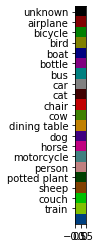

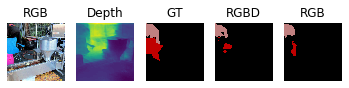

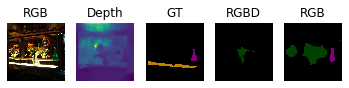

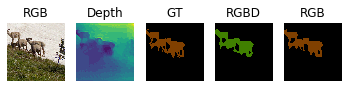

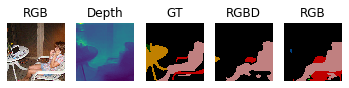

In [12]:
from dataloaders.utils import get_pascal_labels

#Class colors for reference
labels = ['unknown']
labels.extend([x['name'] for x in dataloader.dataset.coco.loadCats(dataloader.dataset.CAT_LIST[1:])])

plt.figure()
plt.imshow(np.expand_dims(get_pascal_labels(), 0).transpose((1, 0, 2)))
plt.yticks(range(20), labels)
print(labels)

# Test images 

for ii, sample in enumerate(dataloader):
    image, target = sample['image'], sample['label']
    display_results(image, target)
    break

plt.show(block=True)


Convolutional Filter Visualization
--------

Code modified from https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb

In [13]:
def sub2ind(array_shape, rows, cols):
    return rows*array_shape[1] + cols + 1

def plot_filters_single_channel(t, fig):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 4
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

def plot_filters_multi_channel(t, fig, num_cols=2, current_col=0):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #rows = num of kernels
    num_rows = num_kernels

    #looping through all the kernels
    for i in range(t.shape[0]):
#         if i == 0:
#             print(t[i])
        ind = sub2ind((num_rows, num_cols), i, current_col)
        ax1 = fig.add_subplot(num_rows,num_cols,ind)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        #TODO Is this normalization the correct way of visualizing? 
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        if len(t.shape) == 4:
            npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])   
    
def plot_weights(layer):
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = layer.weight.data.cpu()
    
    #set the figure size
    num_cols = 2
    num_rows = weight_tensor.shape[0]
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    plot_filters_multi_channel(weight_tensor[:,:3, :, :], fig)
    plot_filters_multi_channel(weight_tensor[:, 3, :, :], fig, current_col=1)
        
  else:
    print("Can only visualize layers which are convolutional")                          
  
  plt.tight_layout()
  plt.show()

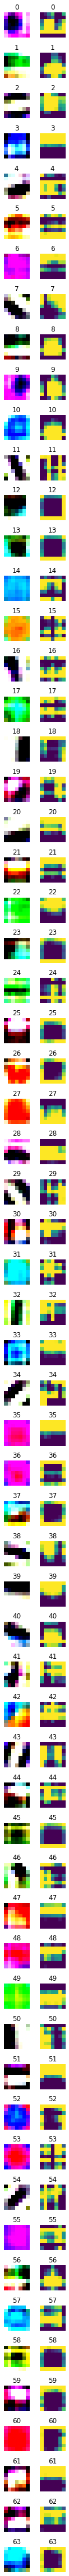

In [14]:
#visualize weights for model - first conv layer
plot_weights(rgbd_model.module.backbone.conv1)


Depth Ablation Study
-----

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


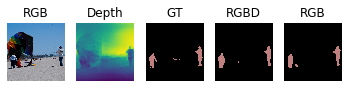

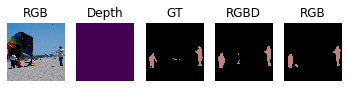

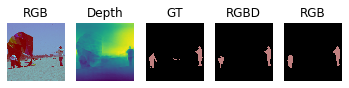

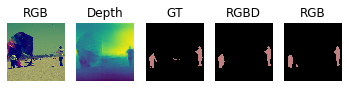

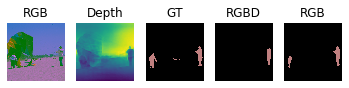

In [15]:
dataloader = DataLoader(coco_val, batch_size=1, shuffle=True, num_workers=0)

for ii, sample in enumerate(dataloader):
    image, target = sample['image'], sample['label']
#     image = image[0, :, :, :].unsqueeze(0)
#     target = target[0, :, :]
    
    # Full RGBD
    display_results(image, target)
    
    # No depth
    rgb_image = image.clone()
    rgb_image[:, 3, :, :] = 0
    display_results(rgb_image, target)
    
    # No red channel 
    gbd_image = image.clone()
    gbd_image[:, 0, :, :] = 0
    display_results(gbd_image, target)
    
     # No blue channel 
    rgd_image = image.clone()
    rgd_image[:, 2, :, :] = 0
    display_results(rgd_image, target)
    
     # No green channel 
    rbd_image = image.clone()
    rbd_image[:, 1, :, :] = 0
    display_results(rbd_image, target)

    break

plt.show(block=True)

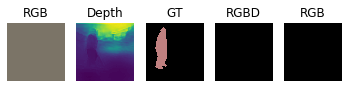

In [16]:
# Depth Only
for ii, sample in enumerate(dataloader):
    image, target = sample['image'], sample['label']
    image[:, 0:3, :, :] = 0
    display_results(image, target)

    break

plt.show(block=True)

Loss Comparison
----


In [17]:
from utils.loss import SegmentationLosses
from utils.metrics import Evaluator
from tqdm import tqdm_notebook

def evaluation(model_name, model, dataloader, loss_type='ce', class_weights=None):
    criterion = SegmentationLosses(weight=class_weights, cuda=model.cuda).build_loss(mode=loss_type)
    evaluator = Evaluator(dataloader.dataset.NUM_CLASSES)
    
    model.eval()
    evaluator.reset()
    tbar = tqdm_notebook(dataloader, desc='\r')
    test_loss = 0.0
    for i, sample in enumerate(tbar):
        image, target = sample['image'], sample['label']
        if model.cuda:
            image, target = image.cuda(), target.cuda()
        with torch.no_grad():
            output = model(image)
        loss = criterion(output, target)
        test_loss += loss.item()
        tbar.set_description('Test loss: %.3f' % (test_loss / (i + 1)))
        pred = output.data.cpu().numpy()
        target = target.cpu().numpy()
        pred = np.argmax(pred, axis=1)
        # Add batch sample into evaluator
        evaluator.add_batch(target, pred)

    # Fast test during the training
    Acc = evaluator.Pixel_Accuracy()
    Acc_class = evaluator.Pixel_Accuracy_Class()
    mIoU = evaluator.Mean_Intersection_over_Union()
    FWIoU = evaluator.Frequency_Weighted_Intersection_over_Union()
    
    print('{}:'.format(model_name))
    print("Acc:{}, Acc_class:{}, mIoU:{}, fwIoU: {}".format(Acc, Acc_class, mIoU, FWIoU))
    print('Loss: %.3f' % test_loss)

In [18]:
dataloader = DataLoader(coco_val, batch_size=4, shuffle=True, num_workers=0)
evaluation('RGBD', rgbd_model, dataloader)

/home/cecilia/anaconda3/envs/detectron2/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/home/cecilia/anaconda3/envs/detectron2/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



RGBD:
Acc:0.8903860500739087, Acc_class:0.5931246700602867, mIoU:0.49490015223151795, fwIoU: 0.810125322884811
Loss: 82.778


In [18]:
coco_val_rgb = COCOSegmentation(args, split='val', year='2017', use_depth=False)
dataloader_rgb = DataLoader(coco_val_rgb, batch_size=4, shuffle=True, num_workers=0)
evaluation('RGB', rgb_model, dataloader_rgb)

loading annotations into memory...
Done (t=0.75s)
creating index...
index created!
Using RGB input


/home/cecilia/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


RGB:
Acc:0.8843406123983548, Acc_class:0.7078214082493784, mIoU:0.5831004736986065, fwIoU: 0.8036406259528369
Loss: 100.132
